# EMNIST Network Project

## Load in libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset #, random_split   # class that processes the dataset 
from torchvision import datasets       # Gets standard data sets from internet
from torchvision.transforms import ToTensor  #, Lambda  
from torch.utils.data import DataLoader
import torch.nn.functional as F


# Decide GPU vs. CPU

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device '.format(device))

Using cpu device 


In [3]:

test_data = datasets.EMNIST(root = "data", 
                                                            split = 'balanced', 
                                                            train = False,
                                                            download = True,
                                                            transform = ToTensor())

batch_size=10
test_dataloader = DataLoader(test_data, 
                                                    batch_size=batch_size, 
                                                    shuffle=True)

In [4]:
import torch.nn.functional as F


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # makes 20 maps of 28x28
        self.conv1 = nn.Conv2d(1, 20, # Channels in/Out 
                                                stride = 1, # Stride
                                                kernel_size = 3,
                                                padding = 1)  # Kernel

        # Keep the size, add 10 more layers
        self.conv2 = nn.Conv2d(20, 30, # Channels in/Out 
                                                stride = 1, # Stride
                                                kernel_size = 3,
                                                padding = 1)  # Kernel

        # Downsampled and thus altering parameters
        self.conv3 = nn.Conv2d(30  , 30 ,
                                                    stride = 1,
                                                    kernel_size = 3,
                                                    padding = 1) 

        # Keeping size and reducing layers
        self.conv4 = nn.Conv2d(30  , 10 ,
                                                    stride = 1,
                                                    kernel_size = 3,
                                                    padding = 1) 
        # Pooling function to divide size in hafl
        self.pool = nn.MaxPool2d(2, 2)   # 40 maps of 4x4
        
        # fully connected layer structure
        self.fc1 = nn.Linear(10 * 7 * 7, 300)                          
        self.fc2 = nn.Linear(300 , 160)                     # Added
        self.fc3 = nn.Linear(160, 120)                       # Added    

    def forward(self, x):
        # Convolutions Period
        # First Round
        x = F.rrelu(self.conv1(x))
        x = F.rrelu(self.conv2(x))
        x = self.pool(x)

        # Second Round
        x = F.rrelu(self.conv3(x))
        x = F.rrelu(self.conv4(x))
        x = self.pool(x)
        # x = self.pool(F.rrelu(self.conv3(x))) # Added

        # Flatten everything in order to pass through FC Layers
        x = torch.flatten(x, 1) # flatten all dimensions except batch

        # Linear Layers
        x = F.rrelu(self.fc1(x))
        x = F.rrelu(self.fc2(x)) # Added 
        x = F.rrelu(self.fc3(x)) # Added
        # x = F.softmax(self.fc4(x), dim =1) # Added
            # Decided against softmax based on Ian/Goodfellow chapter 6 https://stats.stackexchange.com/questions/218752/relu-vs-sigmoid-vs-softmax-as-hidden-layer-neurons
        # x = self.dropout(x) # Added 
            ## Removed because it is just elminating the random variables
        return x
##########################################

model = NeuralNetwork().to(device)

In [5]:
def test_loop(dataloader, model, loss_fn, valid_or_test_flag = "valid"):
    size = len(dataloader.dataset)
    test_loss, correct = 0,0
    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred,y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    if valid_or_test_flag == "test":
        print(f"Test Error: \n Accuracy {(100*correct):>0.1f}%, Avg. loss: {test_loss:>8f} \n")
    else: 
        print(f"Validation Error: \n Accuracy {(100*correct):>0.1f}%, Avg. loss: {test_loss:>8f} \n")

In [6]:
path = 'EMNIST_net.pth'
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load(path))
model.eval()

NeuralNetwork(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(30, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=490, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=160, bias=True)
  (fc3): Linear(in_features=160, out_features=120, bias=True)
)

In [7]:
loss_fn = nn.CrossEntropyLoss()
test_loop(test_dataloader, 
                        model, loss_fn, 
                        valid_or_test_flag = "test")

Test Error: 
 Accuracy 86.3%, Avg. loss: 0.078696 



# Plot the output progression

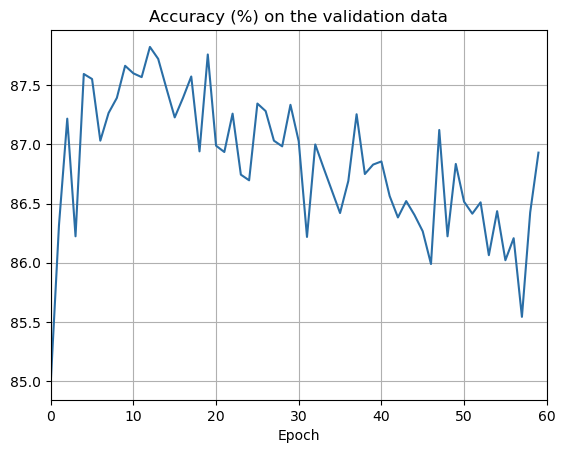

In [8]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_validation_accuracy(validation_correct, num_epochs, validation_accuracy_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(validation_accuracy_xmin, num_epochs), 
            [accuracy*100.0/validation_set_size
             for accuracy in validation_correct[validation_accuracy_xmin:num_epochs]],
            color='#2A6EA6')
    ax.set_xlim([validation_accuracy_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Accuracy (%) on the validation data')
    plt.show()


def make_plots(filename, num_epochs, validation_accuracy_xmin, validation_set_size):
    """Load the results from ``filename``, and generate the corresponding
    plots. """
    f = open(filename, "r")
    validation_correct = json.load(f)
    f.close()
    plot_validation_accuracy(validation_correct, num_epochs, validation_accuracy_xmin)

##### Open the validation and parameters #####
f = open('EMNIST_plot_data.json', "r")
validation_correct = json.load(f)
f.close()

f = open('EMNIST_plot_parameters.json', "r")
[num_epochs, validation_correct_xmin, validation_set_size] = json.load(f)
f.close()


make_plots('EMNIST_plot_data.json', num_epochs, validation_correct_xmin,
           validation_set_size)